<a href="https://colab.research.google.com/github/medulka/LLMs/blob/main/end_to_end_ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**An Example of End-to-End ML Project**

*modified after: Aurélién Géron: Hands-on ML with Sklearn, Teras and TF*



In [ ]:
print("Hello Coworking February 2023!")
print("Hello Nomad March 2024")

Hello Coworking February 2023!
Hello Nomad March 2024


In [ ]:
import sys
assert sys.version_info >= (3,7) # assures Python above 3.7
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1") #needs Scikit learn above 1.0.1

Data **Preparation**

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

# compressed files !!! does not work
def load_housing_data():
  tarball_path = Path("datasets/housing.csv")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path="datasets")
  return pd.read_csv(Path("datasets/housing/housing.csv"))


In [ ]:
from tables.file import parameters
# url = "https://raw.githubusercontent.com/ageron/data/main/housing/housing.csv"

def load_housing_data():
  Path("datasets").mkdir(parents=True, exist_ok=True)
  url = "https://raw.githubusercontent.com/ageron/data/main/housing/housing.csv"
  with urllib.request.urlopen(url) as f:
    data = pd.read_csv(f)
  return data

housing = load_housing_data()
print(housing.head())
print(housing.shape)

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
(20640, 10)


Descriptors' comands

In [ ]:
# housing.info()
housing.head()
# housing.describe()
housing["ocean_proximity"]


0        NEAR BAY
1        NEAR BAY
2        NEAR BAY
3        NEAR BAY
4        NEAR BAY
           ...   
20635      INLAND
20636      INLAND
20637      INLAND
20638      INLAND
20639      INLAND
Name: ocean_proximity, Length: 20640, dtype: object

**Code** **to save the pictures as png**

In [ ]:
IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

**HISTOGRAMS**

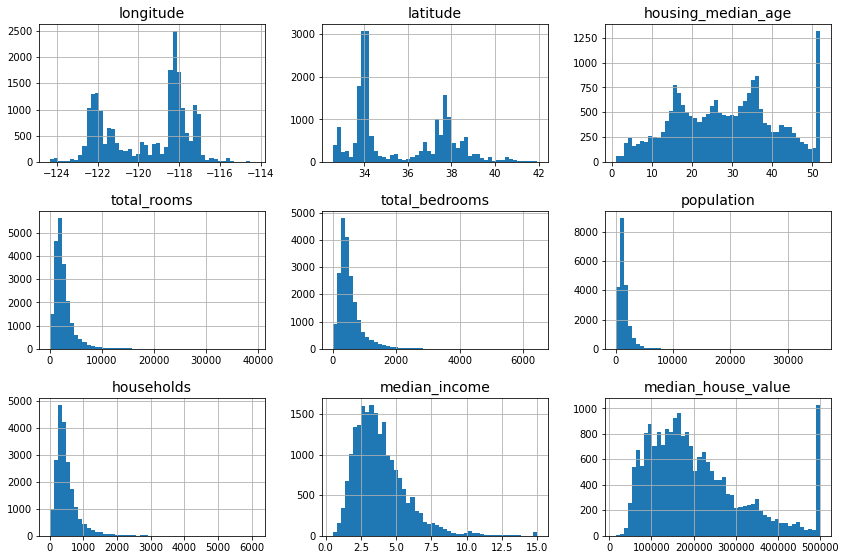

In [ ]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

**Creating a TEST SET**

In [ ]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
  train_set, test_set = shuffle_and_split_data(housing, 0.2)

  print(len(train_set))

16512


In [ ]:
np.random.seed(42) # to ensure, that notebook's outputs remain the same

In [ ]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
  return (crc32(np.int64(identifier)) < test_ratio * 2**32)

def split_data_with_id_hash(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
housing_with_id = housing.reset_index() # add an index column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")
# print(housing.head())
# print(housing_with_id.head())

housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [ ]:
#ML comes on the stage
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [ ]:
test_set["total_bedrooms"].isnull().sum()

44

In [ ]:
# cdf() method  - of the binomial distribution gives us the probability
# that the number of females will be equal or less than the given value

# how to compute the 10.7% proba of getting a bad sample
from scipy.stats import binom

sample_size = 1000
ratio_female = 0.511
proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(proba_too_small + proba_too_large)

0.10736798530929913


In [ ]:
np.random.seed(42)

samples = (np.random.rand(100_000, sample_size) < ratio_female).sum(axis=1)
((samples < 485) | (samples > 535)).mean()

0.1071

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0.,1.5,3.0,4.5,6., np.inf], labels=[1,2,3,4,5])

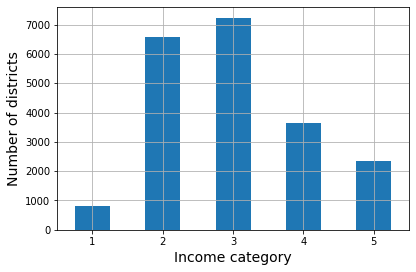

In [ ]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
save_fig("housing_income_bar_plot")
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
  strat_train_set_n = housing.iloc[train_index]
  strat_test_set_n = housing.iloc[test_index]
  strat_splits.append([strat_train_set_n, strat_test_set_n])

In [ ]:
strat_train_set, strat_test_set = strat_splits[0]

In [ ]:
# it is too much shortet to get a single stratified split
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2,
                                                   stratify=housing["income_cat"],
                                                   random_state=42)


In [ ]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [ ]:
def income_cat_proportions(data):
  return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()

compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] / compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] / compare_props["Overall %"] - 1)

(compare_props * 100).round(2)


,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [ ]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

**Discover and Visualize the Data to Gain Insights**

In [ ]:
housing = strat_train_set.copy()
housing.shape

(16512, 10)

**Visualizing Geographical Data**

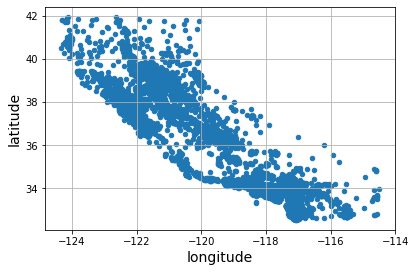

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
save_fig("bad_visualization_plot")
plt.show()

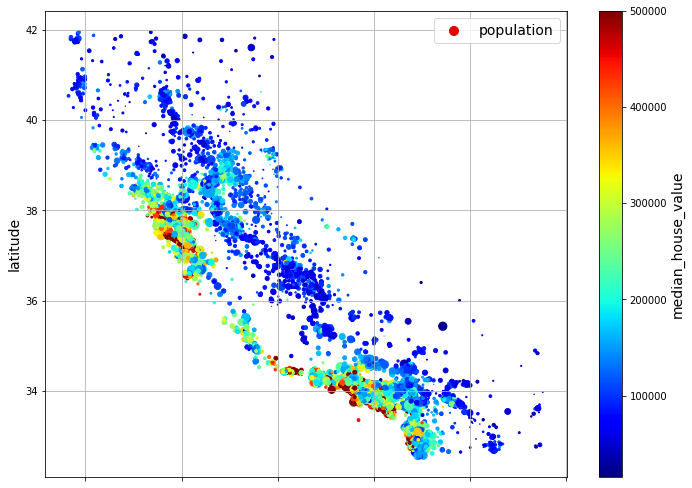

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet",colorbar=True, legend=True,
             sharex=True # fix display bug
             , figsize=(10,7))
save_fig("housing_prices_scatterplot") # extra code
plt.show()

**Drawing the map**

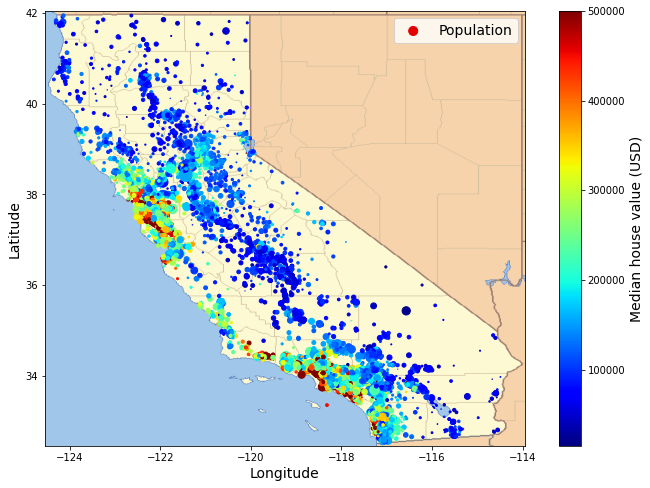

In [ ]:
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
  homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
  url = homl3_root + "images/end_to_end_project/" + filename
  print("Downloading", filename)
  urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude", "population": "Population",
    "median_house_value": "Median house value (USD)"})
housing_renamed.plot(
    kind="scatter", x="Longitude", y="Latitude",
    s=housing_renamed["Population"] / 100, label="Population",
    c="Median house value (USD)", cmap="jet", colorbar=True,
    legend=True, sharex=False, figsize=(10,7))

california_img = plt.imread( IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

save_fig("california_housing_prices_plot")
plt.show()

**Looking for correlations**

In [ ]:
corr_matrix = housing.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

# Nouvelle section

# Nouvelle section

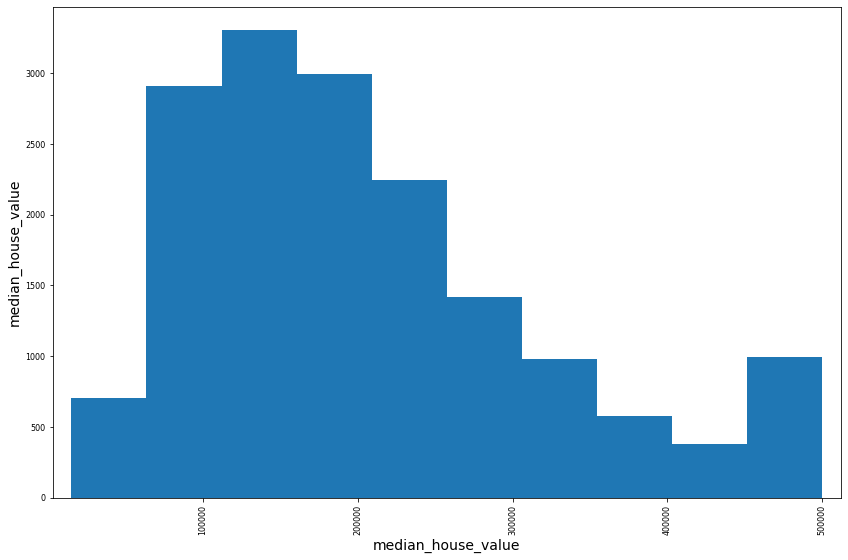

In [ ]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value"]
scatter_matrix(housing[attributes], figsize = (12,8))
save_fig("scatter_matrix_plot")
plt.show()

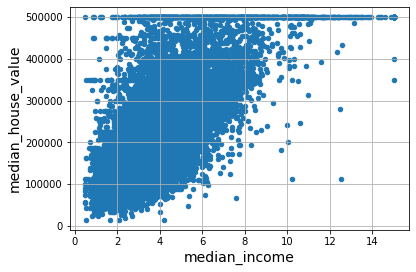

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", grid=True)
save_fig("income_vs_value")
plt.show()

**Experimenting with Attribute Combinations**

In [ ]:
housing["rooms_per_house"] = housing["total_rooms"]/housing["households"]
housing["bed_ratio"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["people_per_house"] = housing["population"]/housing["households"]

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=True)

bed_ratio            -0.256397
latitude             -0.139584
longitude            -0.050859
people_per_house     -0.038224
population           -0.020153
total_bedrooms        0.054635
households            0.071426
housing_median_age    0.102175
total_rooms           0.137455
rooms_per_house       0.143663
median_income         0.688380
median_house_value    1.000000
Name: median_house_value, dtype: float64

**Prepare Data for ML algorithms**

In [ ]:
housing = strat_train_set.drop("median_house_value", axis = 1) #creates a copy without the column, it doesn't modify the original set
housing_labels = strat_train_set["median_house_value"].copy()
housing.shape

(16512, 9)

**Data Cleansing**

In [ ]:
#handling NA values

# option 1
# housing.drop["total_bedrooms"]

# option 2
# housing.dropna(subset = ["total_bedrooms"], inplace = True )

# option 3
# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median, inplace = True)

null_row_idx = housing.isnull().any(axis=1)
housing.loc[null_row_idx].head() #????

# housing_option1 = housing.copy()
# housing_option1.dropna(subset=["total_bedrooms"],inplace=True)
# housing_option1.loc[null_row_idx].head()

# housing_option2 = housing.copy()
# housing_option2.drop("total_bedrooms",axis=1,inplace=True)
# housing_option2.loc[null_row_idx].head()

housing_option3 = housing.copy()
housing_option3

median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median,inplace=True)
housing_option3.loc[null_row_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median") # separating out the numerical attributes

housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [ ]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [ ]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [ ]:
X = imputer.transform(housing_num)

In [ ]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [ ]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)

In [ ]:
housing_tr.loc[null_row_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


In [ ]:
imputer.strategy

'median'

In [ ]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)

In [ ]:
housing_tr.loc[null_row_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


**Droping some outliers**

In [ ]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state = 42)
outlier_pred = isolation_forest.fit_predict(X)
#housing = housing.iloc[outlier_pred == 1]
#housing_labels = housing_labels.loc[outlier_pred == 1]
print(housing.shape)
print(housing_labels)

(16512, 9)
13096    458300.0
14973    483800.0
3785     101700.0
14689     96100.0
20507    361800.0
           ...   
14207    500001.0
13105     88800.0
19301    148800.0
19121    500001.0
19888    233300.0
Name: median_house_value, Length: 16512, dtype: float64


**Handling Text and Categorical Attributes**

In [ ]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head()

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [ ]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

housing_cat1_hot = cat_encoder.fit_transform(housing_cat)
print(housing_cat1_hot)
housing_cat1_hot.toarray()

  (0, 3)	1.0
  (1, 0)	1.0
  (2, 1)	1.0
  (3, 1)	1.0
  (4, 4)	1.0
  (5, 1)	1.0
  (6, 0)	1.0
  (7, 3)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
  (10, 1)	1.0
  (11, 0)	1.0
  (12, 0)	1.0
  (13, 1)	1.0
  (14, 4)	1.0
  (15, 0)	1.0
  (16, 1)	1.0
  (17, 3)	1.0
  (18, 1)	1.0
  (19, 0)	1.0
  (20, 0)	1.0
  (21, 4)	1.0
  (22, 1)	1.0
  (23, 3)	1.0
  (24, 1)	1.0
  :	:
  (16487, 1)	1.0
  (16488, 0)	1.0
  (16489, 0)	1.0
  (16490, 3)	1.0
  (16491, 1)	1.0
  (16492, 4)	1.0
  (16493, 4)	1.0
  (16494, 1)	1.0
  (16495, 0)	1.0
  (16496, 1)	1.0
  (16497, 0)	1.0
  (16498, 0)	1.0
  (16499, 4)	1.0
  (16500, 0)	1.0
  (16501, 0)	1.0
  (16502, 0)	1.0
  (16503, 0)	1.0
  (16504, 0)	1.0
  (16505, 0)	1.0
  (16506, 1)	1.0
  (16507, 0)	1.0
  (16508, 1)	1.0
  (16509, 4)	1.0
  (16510, 0)	1.0
  (16511, 4)	1.0


array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat1_hot = cat_encoder.fit_transform(housing_cat)
housing_cat1_hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND","NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,1,0
1,0,1


In [ ]:
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN","ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,1,0
1,0,1


In [ ]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [ ]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [ ]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [ ]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns = cat_encoder.get_feature_names_out(),
                          index = df_test_unknown.index)

df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


**Feature Scaling**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [ ]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

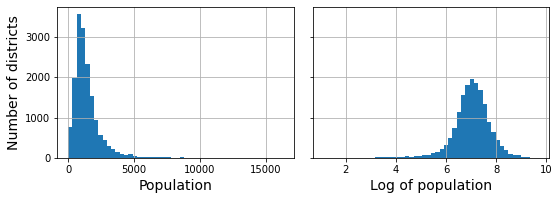

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8,3),sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()

What if we replace each value with its percentile?

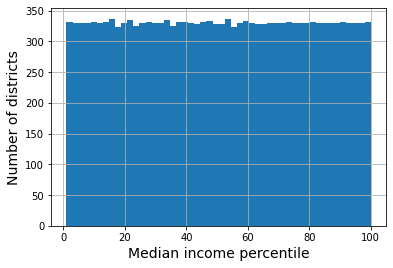

In [ ]:
percentiles = [np.percentile(housing["median_income"],p) for p in range(1,100)]
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels = range(1,100+1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel
age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1) # !!! dvojite zavorky definuji DataFrame, jinak je to Series


#Single Post Underscore is used for naming your variables as Python Keywords and to avoid the clashes by adding an underscore at last of your variable name.

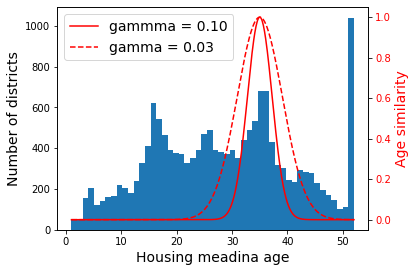

In [ ]:
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1,1)

gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma = gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma = gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing meadina age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()
color = "red"
ax2.plot(ages, rbf1, color=color, label = "gammma = 0.10")
ax2.plot(ages, rbf2, color=color, label = "gamma = 0.03", linestyle = "--")
ax2.tick_params(axis="y", labelcolor = color)
ax2.set_ylabel("Age similarity", color = color)

plt.legend(loc="upper left")
save_fig("age_plot_similarity")

plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5] # pretend this is new data

scaled_predistions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predistions)

In [ ]:
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [ ]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer = StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

type(housing[["median_income"]])

predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

**Custom Transformers**

To create simple transformers:

In [ ]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])
log_pop
housing[["population"]]
type(housing)

pandas.core.frame.DataFrame

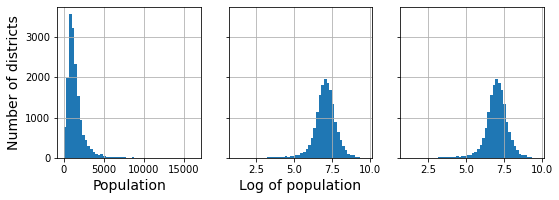

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(8,3),sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
log_pop["population"].hist(bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()

In [ ]:
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma = 0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [ ]:
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

In [ ]:
sf_coords = 37.749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])
sf_simil

array([[0.99972994],
       [0.05358007],
       [0.94570736],
       ...,
       [0.00399074],
       [0.05136069],
       [0.99920821]])

In [ ]:
ratio_transformer = FunctionTransformer(lambda X:X[:, [0]] / X[:,[1]])
ratio_transformer.transform(np.array([[1.,2.], [3.,4.]]))

array([[0.5 ],
       [0.75]])

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
  def __init__(self, with_mean=True):
    self.with_mean = with_mean

  def fit(self, X, y=None):  #y is required even though we don't use it
    X = check_array(X)  #chcecks that X is an array with finite float values
    self.mean_ = X.mean(axis=0)
    self.scale_ = X.std(axis=0)
    self.n_features_in_ = X.shape[1] #every estimator stores this in fit()
    return self #always return self!

  def transform(self, X):
    check_is_fitted(self)
    X = check_array(X)
    assert self.n_features_in_ == X.shape[1]
    if self.with_mean:
      X = X - self.mean_
    return X / self.scale_

In [ ]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
    self.n_clusters = n_clusters
    self.gamma = gamma
    self.random_state = random_state

  def fit(self, X, y=None, sample_weight=None):
    self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
    self.kmeans_.fit(X, sample_weight=sample_weight)
    return self # always return self!

  def transform(self, X):
    return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

  def get_feauture_names_out(self,names=None):
    return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [ ]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

In [ ]:
similarities[:3].round(2)

array([[0.  , 0.14, 0.  , 0.  , 0.  , 0.08, 0.  , 0.99, 0.  , 0.6 ],
       [0.63, 0.  , 0.99, 0.  , 0.  , 0.  , 0.04, 0.  , 0.11, 0.  ],
       [0.  , 0.29, 0.  , 0.  , 0.01, 0.44, 0.  , 0.7 , 0.  , 0.3 ]])

**Transformation Pipelines**

Now let's build a pipeline to preprocess the numerical attributes.

In [ ]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([("impute", SimpleImputer(strategy="median")), ("standardize", StandardScaler())])

In [ ]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [ ]:
from sklearn import set_config
set_config(display="diagram")
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [ ]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [ ]:
def monkey_patch_get_signatures_names_out():
  """Monkey patch some classes which did not handle get_feature_names_out() correctly in Scikit-Learn"""
  from inspect import Signature, signature, Parameter
  import pandas as pd
  from sklearn.impute import SimpleImputer
  from sklearn.pipeline import make_pipeline, Pipeline
  from sklearn.preprocessing import FunctionTransformer, StandardScaler

  default_get_feature_names_out = StandardScaler.get_feature_names_out

  if not hasattr(SimpleImputer, "get_feature_names_out"):
    print("Monkey-patching SimpleImputer.get_feature_names_out()")
    SimpleImputer.get_feature_names_out = default_get_feature_names_out

  if not hasattr(FunctionTransformer, "get_feature_names_out"):
    print("Monkey-patching FunctionTransformer.get_feature_names_out()")
    orig_init = FunctionTransformer.__init__
    orig_sig = signature(orig_init)

    def __init__(*args, feature_names_out=None, **kwargs):
      orig_sig.bind(*args,**kwargs)
      orig_init(*args, **kwargs)
      args[0].feature_names_out = feature_names_out

    __init__.__signature__ = Signature(
        list(signature(orig_init).parameters.values()) +
        [Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

    def get_feature_names_out(self, names=None):
      if callable(self.feature_names_out):
        return self.feature_names_out(self, names)
      assert self.feature_names_out == "one-to-one"
      return default_get_feature_names_out(self, names)

    FunctionTransformer.__init__ = __init__
    FunctionTransformer.get_feature_names_out = get_feature_names_out


monkey_patch_get_signatures_names_out()

Monkey-patching SimpleImputer.get_feature_names_out()
Monkey-patching FunctionTransformer.get_feature_names_out()


In [ ]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)

In [ ]:
df_housing_num_prepared.head(2) # extra code

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942


In [ ]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [ ]:
num_pipeline[1]

StandardScaler()

In [ ]:
num_pipeline[:-1]

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median'))])

In [ ]:
num_pipeline.named_steps["simpleimputer"]

SimpleImputer(strategy='median')

In [ ]:
num_pipeline.set_params(simpleimputer__strategy="median") #double underscore

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
                "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs), ("cat", cat_pipeline, cat_attribs),
])


In [ ]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include = np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)

In [ ]:
# extra code - shows, how you get a DataFrame out if you want
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(10)
# housing_prepared_fr.describe()
# housing_prepared_fr.size


,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789,0.0,1.0,0.0,0.0,0.0
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281,0.0,1.0,0.0,0.0,0.0
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365,0.0,0.0,0.0,0.0,1.0
1286,-0.868193,1.088610,1.861119,-0.370856,-0.561571,-0.668194,-0.472739,-0.276883,0.0,1.0,0.0,0.0,0.0
18078,0.606392,-0.838047,0.430885,-0.710868,-0.808122,-0.837181,-0.893265,1.185526,1.0,0.0,0.0,0.0,0.0
4396,-1.278077,0.830784,0.589800,0.982782,0.858470,0.560383,1.018690,0.811824,0.0,0.0,0.0,1.0,0.0
18031,0.566403,-0.622412,-0.522604,0.248303,0.673556,1.128543,0.642568,-0.593710,1.0,0.0,0.0,0.0,0.0
6753,0.721359,-0.739605,-0.919891,-0.423482,0.080885,0.150248,0.177639,-1.418129,1.0,0.0,0.0,0.0,0.0


In [ ]:
def column_ratio(x):
  return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
  return ["ratio"]  # feature names out

def ratio_pipeline():
  return make_pipeline(
      SimpleImputer(strategy="median"),
      FunctionTransformer(column_ratio, feature_names_out = ratio_name),
      StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out = "one-to-one"),
    StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"] ),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
   # ("people_per_house", ratio_pipeline(), ["population", "households"]),
   # ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
],
remainder=default_num_pipeline) # one column remaining: housing_median_age


In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16344.000000,16512.000000,16512.000000,16512.000000
mean,-119.573125,35.637746,28.577156,2639.402798,538.949094,1425.513929,499.990189,3.870428
std,2.000624,2.133294,12.585738,2185.287466,423.862079,1094.795467,382.865787,1.891936
min,-124.350000,32.550000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.800000,33.930000,18.000000,1447.000000,296.000000,787.000000,279.000000,2.562500
50%,-118.510000,34.260000,29.000000,2125.000000,434.000000,1167.000000,408.000000,3.538500
75%,-118.010000,37.720000,37.000000,3154.000000,645.000000,1726.000000,603.000000,4.750000
max,-114.490000,41.950000,52.000000,39320.000000,6210.000000,16305.000000,5358.000000,15.000100


In [ ]:
housing.shape

(16512, 9)

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 20)

In [ ]:
# preprocessing.get_feature_names_out() nefunguje!!!

**Select and Train a Model**

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7fa...
                                                  ['total_rooms',
                                                   'households']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa33c0429a0>)])),
                ('linearregression', LinearRegression())])

In [ ]:
# out-of-the-main-theme
# default constructor

class DefCon:
  def __init__(self):
    self.construct = 1 + 2  # toto se provede

  # a method for printing data members
  def print_constructor(self):
    print(self.construct)

# creating objects of the class
obj = DefCon()

# calling the instance method using the object obj
print(obj)
obj.print_constructor()

3


In [ ]:
# out-of-the-main-theme
# parameterized constructor

class Addition:
  """an aexample class""" # __doc__ docstring
  first = 0
  second = 0
  answer = 0

  # parameterized constructor
  def __init__(self, f, s):
    self.first = f
    self.second = s

  def display(self):
    print("First number = " + str(self.first))
    print("Second number = " + str(self.second))
    print("Addition of two numbers = " + str(self.answer))

  def calculate(self):    # a function object
    self.answer = self.first + self.second

obj1 = Addition(100,200)

#perform Addition on object obj1
obj1.calculate()
obj1.display()
obj1.first
obj1.second

First number = 100
Second number = 200
Addition of two numbers = 300


200

---

**Classes**

adapted from [python.org](https://docs.python.org/3/tutorial/classes.html#)


A class is a new type of object allowing new instances to be made. Each instance can have attributes attached to it.
Class instance can also have methods.

Objects have individuality.
Alias - pointers.
Namespace - mapping from names to objects.
Most namespaces are currently implemented as Python dictionairies.
Class objects support two types of operations - class instantiation and attribute references (obj.name).

Class instantiation uses a fucntion notation pretending that the class object is a parametereless function that return a new instance of the class.


Eg. x = MyClass() creates a new isntance of the class and assings this object to the local variable x. The isntantiation operation - calling a class object creates an empty object.
A class may define a special method __init__() for the newly created class instance. Instances customized to specific initial state. When a class defines an init method, class instantiation invokes init for the newly created class instance.   

Instance objects
The only operations understood by instance objects are attribute references. There are two types of valid attribute names: data attributes and methods. They spring into existence when tere are first assigned to.
A method of class instance objects.

Classes are not usable to implement pure abstract data types.

Python has two built-in function tath work with inheritance. Base class and derived class. isinstance(obj, int) to check the instance's type. Issubclass() to check the class inheritance.



In [ ]:
class Dog:
  kind = "canine"           # class variable shared by all instances
  # tricks = []             # a bad design,
  def __init__(self, name):
    self.name = name        # instsnce variable unique to each instance
    self.tricks = []        # uses an instance variable, create a unique list for each dog
  def add_trick(self, trick):
    self.tricks.append(trick)


d = Dog("Rosalie")
e = Dog("Unknown gentleman")
d.add_trick("roll over")
e.add_trick("apport")
d.kind    # shared by all dogs
d.name    # unique to d
d.tricks
e.tricks

['apport']

In [ ]:
# generator
def reverse(data):
    for index in range(len(data)-1, -1, -1):
        yield data[index]

# print(list(reverse(housing))) nefunguje!!!

In [ ]:
# the iterator protocol; adding the iterator behaviour to my class
class Reverse:
  """Iterator or looping over a sequence backwards"""
  def __init__(self, data):
    self.data = data
    self.index = len(data)
  def __iter__(self):
    return self
  def __next__(self):
    if self.index == 0:
      raise StopIteration
    self.index = self.index - 1
    return self.data[self.index]

In [ ]:
# testing the full preprocessing pipeline on a few training instances
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2) #-2 rounded to the nearest hundred

array([190100., 329700., 129300.,  68500., 256900.])

In [ ]:
# comparing against the actual values
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [ ]:
# extra code - computer the error ratios discussed in the book
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-58.5%, -31.9%, 27.1%, -28.7%, -29.0%


In [ ]:
from sklearn.metrics import mean_squared_error
lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
lin_rmse

70366.81674906712

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7fa...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa33c0429a0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [ ]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared = False)
tree_rmse

0.0

**Better Evaulation Using Cross-Validation**

In [ ]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, scoring = "neg_root_mean_squared_error", cv=10)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.8/dist-packages/

In [ ]:
pd.Series(tree_rmses).describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64

In [ ]:
# extra code - compute the error stats for the linear model

lin_rmses = -cross_val_score(lin_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.8/dist-packages/

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64

In [ ]:
# housing_labels.describe()
# len(housing)
# print(housing_labels)

# housing["latitude"].count()

housing.axes[0]
# housing.axes[1]
# for i in housing.columns:
#   print(housing[str(i)] )

RangeIndex(start=0, stop=20640, step=1)